## Adding extrinsic noise to the synthetic datasets

Required packages:

In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt

fdir = '../data/'
out_fdir = '../plots/fig12/'

### 0. Loading input data

Same as in the notebook `fig3_architecture.ipynb`, we first load the required promoter sequence and energy matrices.

In [2]:
_genome = []
for record in SeqIO.parse(fdir + "mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

df = pd.read_csv(fdir + 'ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

We manually specify the binding site sequences. Note that these sequences all need to be contained within the promoter sequence itself.

In [3]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
rep_site = 'AATTGTGAGCGGATAACAATT'

We read in the known energy matrix for RNA polymerase. This energy matrix is experimentally determined and shown in Figure 2 of Brewster et al., 2012. (https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002). We use the function `fix_wt` from the `tregs` package to normalize the energy matrix such that the wild type base identities correspond to a binding energy of $0\ k_BT$.

In [4]:
rnap_emat_raw = np.loadtxt(fdir + 'energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

Similarly, we read in the experimentally determined energy matrix for the lacI repressor (Barnes et al., 2019) and normalize the energy matrix.

In [5]:
O1_1027_raw = np.load(fdir + 'energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### 1.1 Building information footprint when the number of RNAPs/repressors exists on a Log-Normal distribution

In order to simulate extrinsic noise, we define two functions `get_parameters` and `simrep_pbound_with_noise`. `simrep_pbound_with_noise` defines the expression for probability of RNAP being bound when the copy number of RNAP and repressors are drawn from a Log-Normal distribution. `get_paramters` is a helper function that allows us to convert the mean and coefficient of variation of the Log-Normal distribution to `mu` and `sigma` used by the `rng.lognormal` function.

In [6]:
def get_parameters(mean, cov):
	"""
    Calculate parameters for a Log-Normal distribution given the mean and coefficient of variation.

    Parameters:
    ----------
    mean : float
        Mean of the distribution.
    cov : float
        Coefficient of variation, defined as the standard deviation divided by the mean.

    Returns:
    -------
    mu : float
        The log-transformed mean (mu) parameter for the Log-Normal distribution.
    sigma : float
        The scale (sigma) parameter for the Log-Normal distribution.
    """
	mu = np.log(mean)
	alpha = np.sqrt(np.log(cov**2 + 1)) / np.log(mean)
	sigma = alpha * np.log(mean)
	return mu, sigma

def simrep_pbound_with_noise(p_seq, r_seq, n_NS,
							 p_emat, r_emat, ep_wt, er_wt,
							 mean_p, mean_r, cov):
	
    """
    Simulate the probability of RNAP being bound in the presence of noise, modeled by log-normal distributions.

    Parameters
    ----------
    p_seq : str
        Sequence of the RNAP binding site.
    r_seq : str
        Sequence of the repressor binding site.
    n_NS : float
        Scaling factor for non-specific binding.
    p_emat : array-like
        Energy matrix for RNAP.
    r_emat : array-like
        Energy matrix for repressor.
    ep_wt : float
        Wild-type binding energy for RNAP.
    er_wt : float
        Wild-type binding energy for the repressor.
    mean_p : float
        Mean copy number of RNAP.
    mean_r : float
        Mean copy number of repressors.
    cov : float
        Coefficient of variation.

    Returns
    -------
    float
        The probability of RNAP being bound.
    """

    rng = np.random.default_rng()
	
    mu_p, sigma_p = get_parameters(mean_p, cov)
    mu_r, sigma_r = get_parameters(mean_r, cov)

    n_p = rng.lognormal(mu_p, sigma_p, 1)[0]
    n_r = rng.lognormal(mu_r, sigma_r, 1)[0]
	
    w_p = tregs.simulate.get_weight(p_seq, p_emat, e_wt=ep_wt)
    w_r = tregs.simulate.get_weight(r_seq, r_emat, e_wt=er_wt)

    z = np.zeros(3)
    z[0] = 1
    z[1] = n_p / n_NS * w_p
    z[2] = n_r / n_NS * w_r

    return z[1] / np.sum(z)

For convenience, we define the function below `get_signal` where we calculate the average mutual information at a binding site given the footprint and the left and right indices of the binding site.

In [7]:
def get_signal(footprint, region_param):
    """
    Calculate the total mutual information within a binding site and the length of the binding site.

    Parameters:
    ----------
    footprint : array-like
        Array containing mutual information of a promoter.
    region_param : tuple of int
        Tuple specifying the start and end indices (inclusive) of the binding site.

    Returns:
    -------
    signal : float
        The sum of the mutual information within the binding site.
    length : int
        The length of the binding site.
    """
    signal = np.sum(footprint[(region_param[0]+115):(region_param[1]+116)])
    length = region_param[1] - region_param[0] + 1
    return signal, length

For each inducer concentration, we simulate 20 synthetic datasets in order to observe the average effects. To save computational time, we first generate 20 mutant libraries beforehand using the function `mutations_rand`.

In [8]:
mutant_bank = []
for i in range(20):
    mutants = np.unique(tregs.wgregseq.mutations_rand(promoter,
                                                rate=0.1,
                                                num_mutants=5000,
                                                number_fixed=True,
                                                keep_wildtype=True))
    mutant_bank.append(mutants)

We define the usual parameters needed for a simple repression thermodynamic model and we vary the coefficient of variation in order to vary the level of extrinsic noise. For each coefficient of variation, we build synthetic datasets for each of the 20 pre-generated synthetic dataset by using the function `simrep_pbound_with_noise` as an argument for the `tregs.simulate.sim` function and we keep track of the average mutual information at the -35 and -10 RNAP binding sites and at the repressor binding site.

In [9]:
n_NS = len(genome)
ep_wt = -5
er_wt = -15
mean_p = 5000
mean_r = 100

l_cov = 10 ** np.arange(-1, 2.1, 0.1)
        
l_stn_ratio_rnap10 = []
l_stn_ratio_rnap35 = []
l_stn_ratio_lacI = []
for cov in l_cov:
    rnap10 = []
    rnap35 = []
    lacI = []
    for j in range(20):
        df = tregs.simulate.sim(promoter, simrep_pbound_with_noise, [rnap_site, rep_site], 
                                *[n_NS, rnap_emat, rep_emat, ep_wt, er_wt,
                                    mean_p, mean_r, cov],
                                preset_mutants=mutant_bank[i])
        
        nbins = 2
        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        upper_bound = np.mean(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                pseudocount=10**(-6))
        
        region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
        rnap35_signal, rnap35_length = get_signal(footprint, region_params[0])
        rnap10_signal, rnap10_length = get_signal(footprint, region_params[1])
        lacI_signal, lacI_length = get_signal(footprint, region_params[2])

        total_signal = rnap35_signal + rnap10_signal + lacI_signal
        total_noise = np.sum(footprint) - total_signal
        mean_noise = total_noise / (160 - (rnap35_length + rnap10_length + lacI_length))
        
        rnap10.append(rnap10_signal / rnap10_length / mean_noise)
        rnap35.append(rnap35_signal / rnap35_length / mean_noise)
        lacI.append(lacI_signal / lacI_length / mean_noise)
    l_stn_ratio_rnap10.append(np.mean(rnap10))
    l_stn_ratio_rnap35.append(np.mean(rnap35))
    l_stn_ratio_lacI.append(np.mean(lacI))

The average mutual information at each of the three binding sites is plotted against the coefficient of variation on a log scale.

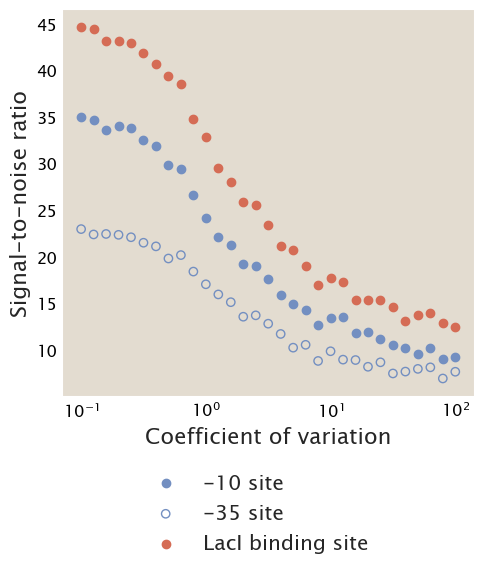

In [10]:
fig, ax = plt.subplots(figsize=(5, 6))
ax.scatter(l_cov, l_stn_ratio_rnap10, label='-10 site', color='#738FC1')
ax.scatter(l_cov, l_stn_ratio_rnap35, label='-35 site', facecolors='none', edgecolors='#738FC1', )
ax.scatter(l_cov, l_stn_ratio_lacI, label='LacI binding site',
           color='#D56C55')
ax.set_xlabel('Coefficient of variation', fontsize=16)
ax.set_ylabel('Signal-to-noise ratio',fontsize=16)
ax.legend(bbox_to_anchor=(0.79, -0.15), frameon=False, fontsize=15)
ax.set_xscale('log')

plt.tight_layout()
plt.savefig(out_fdir + 'extrinsic_noise.pdf')

### 1.2 Example information footprints with different levels of extrinsic noise

Information footprint with low extrinsic noise (coefficient of variation = 0.2)

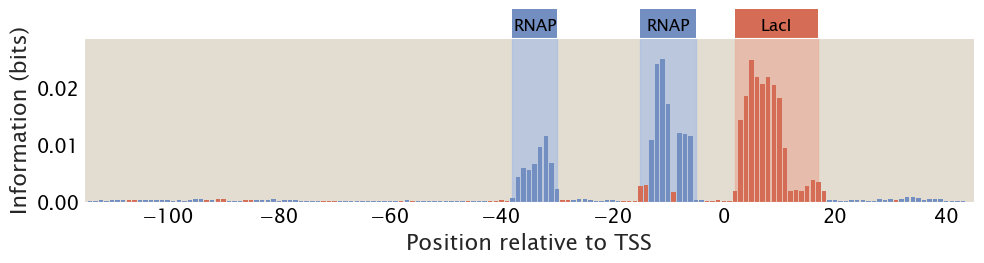

In [11]:
n_NS = len(genome)
ep_wt = -5
er_wt = -15

mean_p = 5000
mean_r = 100
cov = 0.2

df = tregs.simulate.sim(promoter, simrep_pbound_with_noise, [rnap_site, rep_site], 
                        *[n_NS, rnap_emat, rep_emat, ep_wt, er_wt,
                          mean_p, mean_r, cov])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               outfile=out_fdir + 'extrinsic_noise_fp1.pdf')

Information footprint with low extrinsic noise (coefficient of variation = 2)

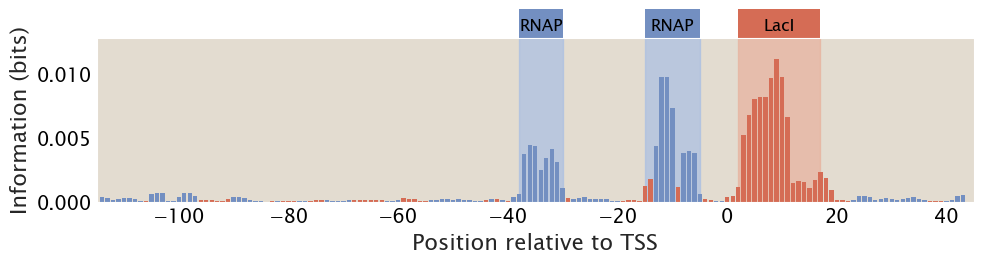

In [12]:
n_NS = len(genome)
ep_wt = -5
er_wt = -15

mean_p = 5000
mean_r = 100
cov = 2

df = tregs.simulate.sim(promoter, simrep_pbound_with_noise, [rnap_site, rep_site], 
                        *[n_NS, rnap_emat, rep_emat, ep_wt, er_wt,
                          mean_p, mean_r, cov])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               outfile=out_fdir + 'extrinsic_noise_fp2.pdf')

Information footprint with low extrinsic noise (coefficient of variation = 100)

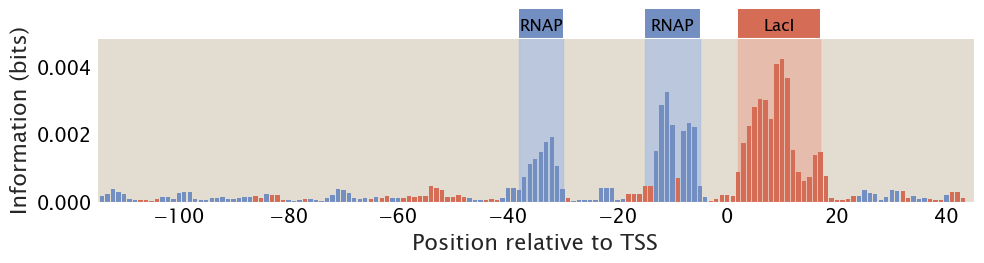

In [13]:
n_NS = len(genome)
ep_wt = -5
er_wt = -15

mean_p = 5000
mean_r = 100
cov = 100

df = tregs.simulate.sim(promoter, simrep_pbound_with_noise, [rnap_site, rep_site], 
                        *[n_NS, rnap_emat, rep_emat, ep_wt, er_wt,
                          mean_p, mean_r, cov])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               outfile=out_fdir + 'extrinsic_noise_fp3.pdf')